In [2]:
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import integrate as sinteg

import integrated_bispectrum

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Note: redshifts have been re-sorted (earliest first)


/global/u2/o/omard/fgcmblensing/bispectrum/integrated_bispectrum.py:218: RuntimeWarning: divide by zero encountered in divide
  Wphiphiv = np.nan_to_num(-2*(chistar-chis)/(chistar*chis))


In [3]:
#https://github.com/toshiyan/cmblensplus/blob/dcd212906da8039f63839d69e8bb45ebccd55d09/F90/src_utils/bstool.f90#L988
def W3j_approx(l1,l2,l3):
  #ind = np.where((l1+l2+l3)%2 != 0)
  if (l1+l2+l3)%2 != 0:
    result = 0
  else:
    Lh = (l1+l2+l3)*0.5
    a1 = ((Lh-l1+0.5)/(Lh-l1+1))**(Lh-l1+0.25)
    a2 = ((Lh-l2+0.5)/(Lh-l2+1))**(Lh-l2+0.25)
    a3 = ((Lh-l3+0.5)/(Lh-l3+1))**(Lh-l3+0.25)
    b = 1/((Lh-l1+1)*(Lh-l2+1)*(Lh-l3+1))**(0.25)
    result = (-1)**Lh/np.sqrt(2*np.pi) * np.exp(1.5)* (Lh+1)**(-0.25) * a1*a2*a3*b
  #result[ind] = 0
  return result

In [4]:
@np.vectorize
def geom_factor(l1, l2, l3):
    result = np.sqrt((2*l1+1)*(2*l2+1)*(2*l3+1)/(4*np.pi))
    result *= W3j_approx(l1, l2, l3)
    return result


In [5]:
@np.vectorize
def integrate_bispectrum_kkk(l1, l2, l3, angle12, angle13, angle23, model = 'TR'):
    bispectrum_at_ells_of_chi = lambda chi: chi**(-4)*integrated_bispectrum.Wkk(chi)**3*integrated_bispectrum.bispectrum_matter(l1/chi, l2/chi, l3/chi, angle12, angle13, angle23, integrated_bispectrum.zofchi(chi), model = model)
    return sinteg.quadrature(bispectrum_at_ells_of_chi, 0, integrated_bispectrum.chistar)[0]

In [6]:
integrate_bispectrum_kkk_single = lambda l: integrate_bispectrum_kkk(l, l, l)

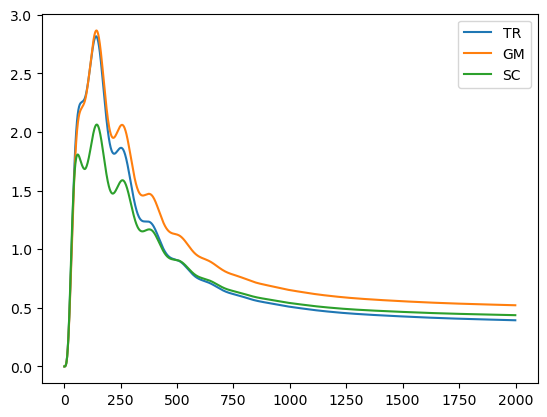

In [7]:
ls = np.arange(1, 2000)
models = ['TR', 'GM', 'SC']
for model in models:
    angle12, angle13, angle23 = np.pi/3, np.pi/3, np.pi/3
    calculated = integrate_bispectrum_kkk(ls, ls, ls, angle12, angle13, angle23, model = model)#list(map(integrate_bispectrum_kkk_single, ls))
    plt.plot(ls, calculated*1e9*ls**2, label = model)
#plt.xscale('log')
plt.legend()

In [ ]:
import vegas

lmin, lmax = 0, 4000

integ = vegas.Integrator([[lmin, lmax], [0, 2*np.pi], [lmin, lmax], [0, 2*np.pi]])
nitn, neval = 10, 1e3

values = []

Rs = np.linspace(0.1, 6, 10)

models = ['TR', 'GM']
results = {}
for model in models:
    values = []
    for R in Rs:

        Rdeg = R/60
        Rradians = np.deg2rad(Rdeg)
        sigma = Rradians / (2.0 * np.sqrt(2.0 * np.log(2.0)))
        WR = lambda l: np.exp(-(l*(l+1))/2/sigma**2)

        @vegas.batchintegrand
        def integrand(x):
            l, thetal = x[:, 0], x[:, 1]
            L, thetaL = x[:, 2], x[:, 3]

            lx, ly = np.cos(thetal)*l, np.sin(thetal)*l
            Lplx = L*np.cos(thetaL)+lx
            Lply = L*np.sin(thetaL)+ly
            Lplv = np.array([Lplx, Lply])
            Lpl = np.linalg.norm(Lplv, axis = 0)
            angle12 = abs(thetal-thetaL)
            angle13 = abs(np.arctan((Lply-ly)/(Lplx-lx))) 
            angle23 = np.pi-angle12-angle13
            value = WR(L)*WR(l)*WR(Lpl)*integrate_bispectrum_kkk(l, L, Lpl, angle12, angle13, angle23, model = model)*geom_factor(l, L, Lpl)**2
            return value/(2*np.pi)**2/(2*np.pi)**2

        result = integ(integrand, nitn = nitn, neval = neval)
        values += [result.mean]
        
    Rs, values = np.array(Rs), np.array(values)
    results[model] = values

In [27]:
lmin, lmax = 100, 3000
Ls = np.arange(lmin, lmax)
#L1M, L2M, L3M = np.meshgrid(Ls, Ls, Ls)

In [ ]:
values = []

Rs = np.linspace(0.1, 6, 10)

models = ['TR', 'GM']
results = {}

def get_angle_12(L1, L2, L3):
    term = (L1**2+L2**2-L3**2)/(2*L1*L2)
    return np.arccos(term)

for model in models:
    values = []
    for R in Rs:

        Rdeg = R/60
        Rradians = np.deg2rad(Rdeg)
        sigma = Rradians / (2.0 * np.sqrt(2.0 * np.log(2.0)))
        WR = lambda l: np.exp(-(l*(l+1))/2*sigma**2)

        @np.vectorize
        def integrand(L1, L2, L3):
            angle12 = get_angle_12(L1, L2, L3)
            angle13 = get_angle_12(L1, L3, L2)
            angle23 = get_angle_12(L2, L3, L1)
            value = WR(L1)*WR(L2)*WR(L3)*integrate_bispectrum_kkk(L1, L2, L3, angle12, angle13, angle23, model = model)*geom_factor(L1, L2, L3)**2
            return value


        
        somma = 0
        '''
        for L1 in Ls:
            print('Do', L1)
            for L2 in range(L1, Ls.max()):
                for L3 in range(L2, Ls.max()):
                    if (L3>L1+L2) or (L3<abs(L1-L2)):
                        continue
                    if (L1>L2+L3)or (L1<abs(L2-L3)):
                        continue
                    if (L2>L3+L1) or (L2<abs(L3-L1)):
                        continue
                    if ((L1+L3+L3)%2==1):
                        continue
                    somma += integrand(L1, L2, L3)
        '''
        
        somma = 0
        for L1 in Ls:
            print(R, L1)
            L2 = np.arange(L1-2, Ls.max())
            L3 = L2
            
            vect_ = np.vectorize(lambda LL: integrand(L1, LL, LL))
            somma += np.sum(vect_(L2))
            
            #sel = np.where((L3>L1+L2))
            '''
            if (L1>L2+L3)or (L1<abs(L2-L3)):
                continue
            if (L2>L3+L1) or (L2<abs(L3-L1)):
                continue
            if ((L1+L3+L3)%2==1):
                continue
            '''
            
        result = 6*somma
        values += [result]
        
    Rs, values = np.array(Rs), np.array(values)
    results[model] = values

0.1 100
0.1 101
0.1 102
0.1 103
0.1 104
0.1 105
0.1 106
0.1 107
0.1 108
0.1 109
0.1 110
0.1 111
0.1 112
0.1 113
0.1 114
0.1 115
0.1 116
0.1 117
0.1 118
0.1 119
0.1 120
0.1 121
0.1 122
0.1 123
0.1 124
0.1 125
0.1 126
0.1 127
0.1 128
0.1 129
0.1 130
0.1 131
0.1 132
0.1 133
0.1 134
0.1 135
0.1 136
0.1 137
0.1 138
0.1 139
0.1 140
0.1 141
0.1 142
0.1 143
0.1 144
0.1 145
0.1 146
0.1 147
0.1 148
0.1 149
0.1 150
0.1 151
0.1 152
0.1 153
0.1 154
0.1 155
0.1 156
0.1 157
0.1 158
0.1 159
0.1 160
0.1 161
0.1 162
0.1 163
0.1 164
0.1 165
0.1 166
0.1 167
0.1 168
0.1 169
0.1 170
0.1 171
0.1 172
0.1 173
0.1 174
0.1 175
0.1 176
0.1 177
0.1 178
0.1 179
0.1 180
0.1 181
0.1 182
0.1 183
0.1 184
0.1 185
0.1 186
0.1 187
0.1 188
0.1 189
0.1 190
0.1 191
0.1 192
0.1 193
0.1 194
0.1 195
0.1 196
0.1 197
0.1 198
0.1 199
0.1 200
0.1 201
0.1 202
0.1 203
0.1 204
0.1 205
0.1 206
0.1 207
0.1 208
0.1 209
0.1 210
0.1 211
0.1 212
0.1 213
0.1 214
0.1 215
0.1 216
0.1 217
0.1 218
0.1 219
0.1 220
0.1 221
0.1 222
0.1 223
0.1 224


In [ ]:
somma

In [29]:
results_sims = np.load('../iterativeforegroundsfullsky/itfgs/notebooks/results.npy', allow_pickle = True).take(0)
results_G = np.load('../iterativeforegroundsfullsky/itfgs/notebooks/resultsG.npy', allow_pickle = True).take(0)

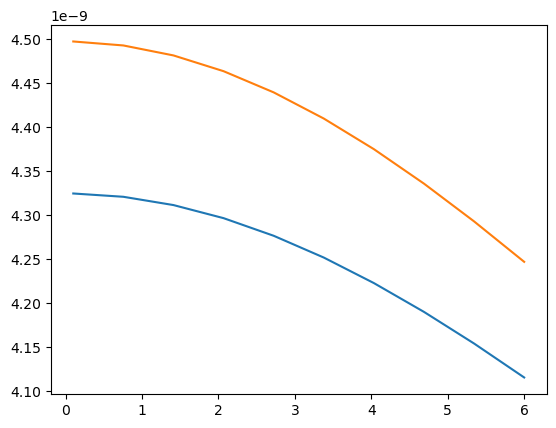

In [19]:
for k, values in results.items():
    plt.plot(Rs, values, label = k)

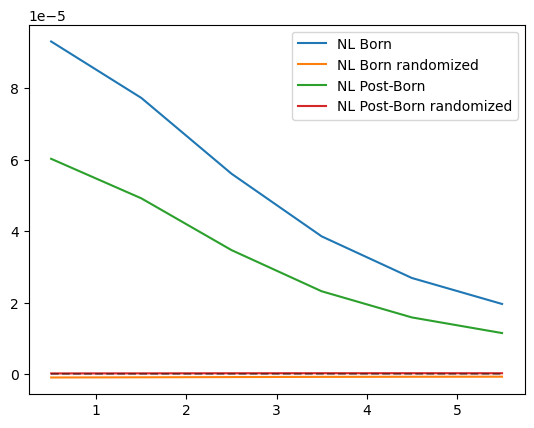

In [30]:
for k, values in results.items():
    plt.plot(Rs, values*1e4, label = k)

fwhms = np.arange(0.5, 6, 1.)
for k, skews in results_sims.items():
    plt.plot(fwhms, np.array(skews), label = k)
plt.hlines(0, fwhms.min(), fwhms.max(), ls = '--', color = 'k', alpha = 0.4)
plt.legend()